In [97]:
import warnings
warnings.filterwarnings('ignore')

In [116]:
import pandas as pd
import numpy as np
import math
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation
from pandas.plotting import autocorrelation_plot

## Getting data

In [81]:
df = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
df['Month'] = df['Month'].apply(lambda x: dt(int(x[:4]), int(x[5:]), 15))
print(df.head())

       Month  Passengers
0 1949-01-15         112
1 1949-02-15         118
2 1949-03-15         132
3 1949-04-15         129
4 1949-05-15         121


## Some analysis

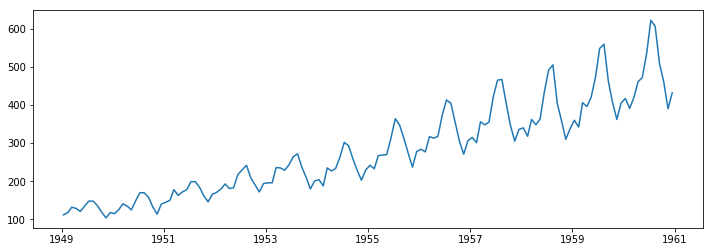

In [103]:
y = pd.Series(data=df['Passengers'].values, index=df['Month'])
plt.plot(y)

There is seasonility and trend in this serie

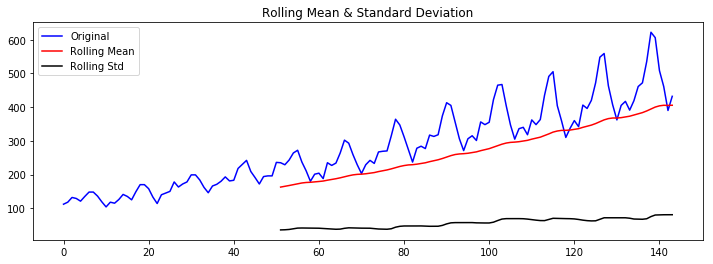

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [111]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(df['Passengers'])

Choosing the critical value at 0.05, the above conducted Dickey-Fuller test shows this serie is not stationary (p-value is greater than 0.05).

Let's transform into stationary

In [165]:
ts_log_mv_diff = df.copy() 
ts_log_mv_diff['Passengers'] = df['Passengers'].apply(lambda x: math.log(x)).rolling(window=2,center=False).mean().diff(1)
ts_log_mv_diff.dropna(inplace = True)

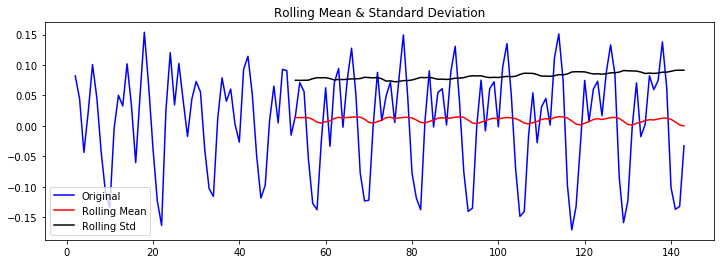

Results of Dickey-Fuller Test:
Test Statistic                  -3.167907
p-value                          0.021919
#Lags Used                      11.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [190]:
test_stationarity(ts_log_mv_diff['Passengers'])

Choosing the critical value at 0.05, the above conducted Dickey-Fuller test shows this serie is now stationary (p-value is lesser than 0.05).

.

## Models

### 1. LSTM

In [47]:
def create_model():
    model = Sequential()
    model.add(LSTM(units=256,input_shape=(None,1),return_sequences=True))
    model.add(LSTM(units=256))
    model.add(Dense(units=1))
    model.add(Activation('linear'))
    model.compile(loss='mse',optimizer='adam')
    return model

In [48]:
scaler_minmax = MinMaxScaler()
data = scaler_minmax.fit_transform(df)
infer_seq_length = 10

d = []
for i in range(data.shape[0]-infer_seq_length):
    d.append(data[i:i+infer_seq_length+1].tolist())
d = np.array(d)

In [49]:
#separate train,test
split_rate = 0.9
X_train, y_train = d[:int(d.shape[0]*split_rate),:-1], d[:int(d.shape[0]*split_rate),-1]

In [50]:
model =create_model()

In [51]:
model.fit(X_train, y_train, batch_size=20,epochs=100,validation_split=0.1)

Train on 108 samples, validate on 12 samples
Epoch 1/100
108/108 [==============================] - 2s 21ms/step - loss: 0.0538 - val_loss: 0.0407
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0549
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0102 - val_loss: 0.0320
Epoch 4/100
108/108 [==============================] - 0s 5ms/step - loss: 0.0093 - val_loss: 0.0329
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0127 - val_loss: 0.0264
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0242
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0114 - val_loss: 0.0396
Epoch 8/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0094 - val_loss: 0.0272
Epoch 9/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0326
Epoch 10/100
108/108 [=======================

Epoch 81/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0082
Epoch 82/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0059
Epoch 83/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0077
Epoch 84/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0023 - val_loss: 0.0069
Epoch 85/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0064
Epoch 86/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0026 - val_loss: 0.0062
Epoch 87/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0024 - val_loss: 0.0060
Epoch 88/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0021 - val_loss: 0.0077
Epoch 89/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0022 - val_loss: 0.0065
Epoch 90/100
108/108 [==============================] - 0s 4ms/step - loss: 0.0023

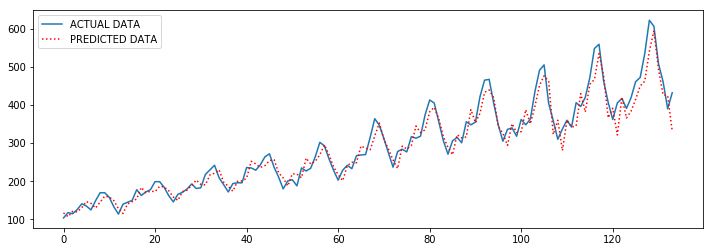

In [105]:
plt.plot(scaler_minmax.inverse_transform(d[:,-1]),label='ACTUAL DATA')
plt.plot(scaler_minmax.inverse_transform(model.predict(d[:,:-1])),'r:',label='PREDICTED DATA')
plt.legend()

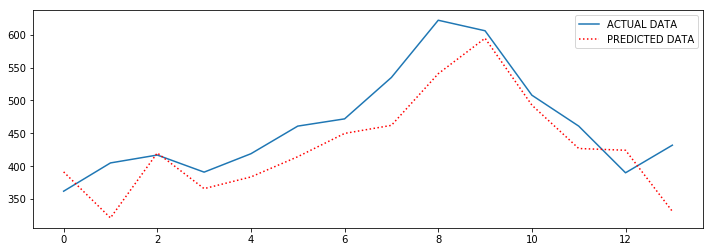

In [106]:
plt.plot()
plt.plot(scaler_minmax.inverse_transform(d[int(len(d)*split_rate):,-1]),label='ACTUAL DATA')
plt.plot(scaler_minmax.inverse_transform(model.predict(d[int(len(d)*split_rate):,:-1])),'r:',label='PREDICTED DATA')
plt.legend()

### 2.TIME SERIES

In [132]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA

### ACF

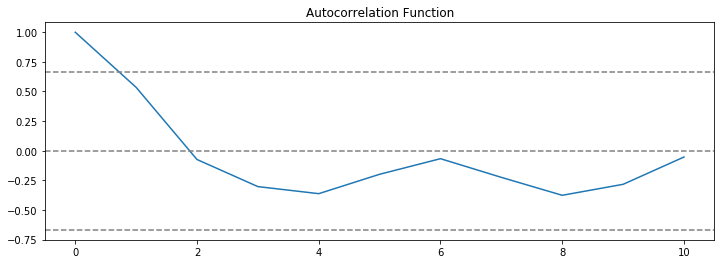

In [133]:
#using serie without seasonility
plt.plot(np.arange(0,11), acf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()

### PACF

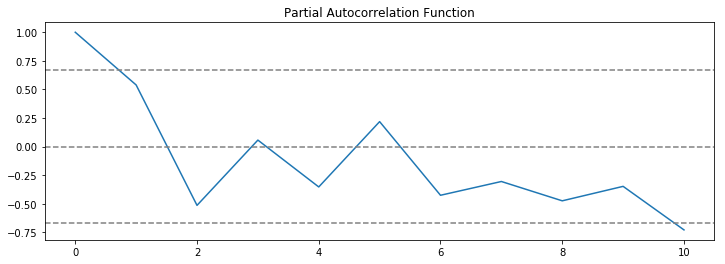

In [137]:
plt.plot(np.arange(0,11), pacf(ts_log_mv_diff, nlags = 10))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_mv_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

Looking where ACF and PACF cross lag lines:

* From ACF, optimal value of q in the ARIMA model must be 0 or 1.
* From PACF, optimal value of p in the ARIMA model is 1 or 2.

In [193]:
model = ARIMA(ts_log, order=(1, 1, 0))  
results_ARIMA = model.fit(disp=-1)  

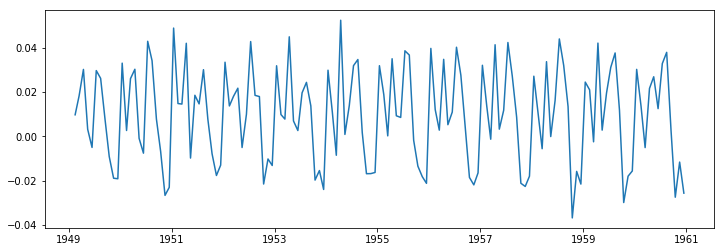

In [200]:
plt.plot(results_ARIMA.fittedvalues)

In [175]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions_ARIMA_diff.head()

Month
1949-02-15    0.009676
1949-03-15    0.018164
1949-04-15    0.030130
1949-05-15    0.003154
1949-06-15   -0.005039
dtype: float64

In [176]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

Month
1949-02-15    0.009676
1949-03-15    0.027839
1949-04-15    0.057969
1949-05-15    0.061123
1949-06-15    0.056084
dtype: float64

In [177]:
predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Month
1949-01-15    4.718499
1949-02-15    4.728175
1949-03-15    4.746338
1949-04-15    4.776468
1949-05-15    4.779622
dtype: float64

Text(0.5,1,'RMSE: 52.1841')

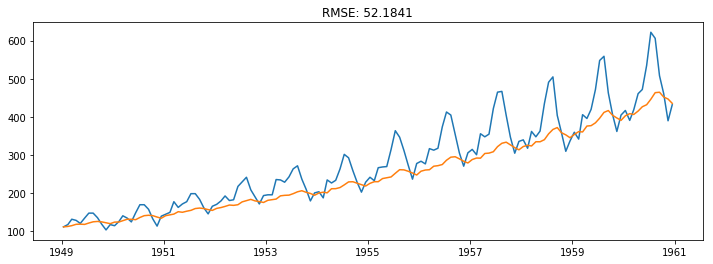

In [178]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))